# Bias Removal

Climate models can have biases relative to different verification datasets. Commonly, biases are removed by postprocessing before verification of forecasting skill. `climpred` provides convenience functions to do so.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import climpred
import xarray as xr
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble

<IPython.core.display.Javascript object>

In [3]:
hind = climpred.tutorial.load_dataset(
    "CESM-DP-SST"
)  # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset("ERSST")  # observations
hind["lead"].attrs["units"] = "years"

<IPython.core.display.Javascript object>

We begin by removing a mean climatology for the observations, since `CESM-DPLE` generates its anomalies over this same time period.

In [4]:
obs = obs - obs.sel(time=slice("1964", "2014")).mean("time")

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/utils.py:122: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='SST'>

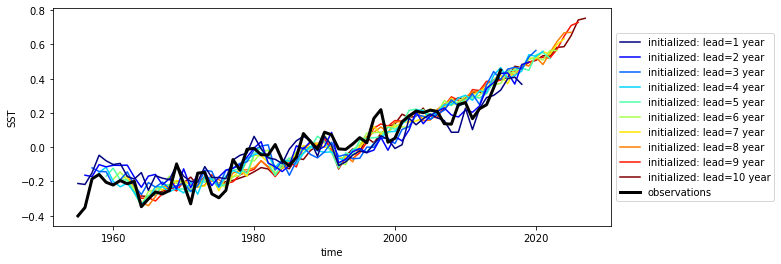

<IPython.core.display.Javascript object>

In [5]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_observations(obs)
hindcast.plot()

The warming of the `observations` is similar to `initialized`.

## Mean bias removal

Typically, bias depends on lead-time and therefore should therefore also be removed depending on lead-time.

In [6]:
bias = hindcast.verify(metric="bias", comparison="e2o", dim=[], alignment="same_verifs")

<IPython.core.display.Javascript object>

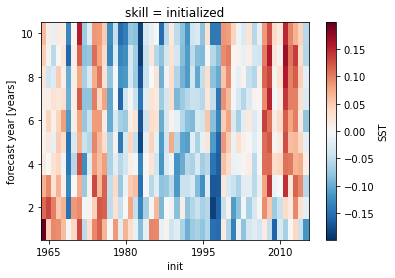

<IPython.core.display.Javascript object>

In [7]:
bias.SST.plot()

Against `observations`, there is small cold bias in 1980 and 1990 initialization years and warm bias before and after.

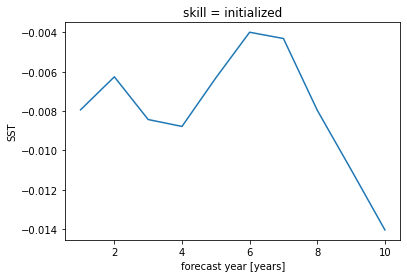

<IPython.core.display.Javascript object>

In [8]:
# lead-time dependant mean bias over all initializations is quite small but negative
mean_bias = bias.mean("init")
mean_bias.SST.plot()

### Cross Validatation
To remove the mean bias quickly, the mean bias over all initializations is subtracted. For formally correct bias removal with cross validation, the given initialization is left out when subtracting the mean bias.

`climpred` wraps these functions in `HindcastEnsemble.remove_bias(how='mean', cross_validate={bool})`.

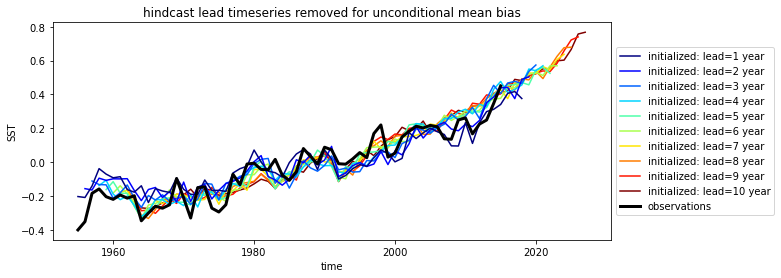

<IPython.core.display.Javascript object>

In [9]:
hindcast.remove_bias(how="mean", cross_validate=True, alignment="same_verifs").plot()
plt.title("hindcast lead timeseries removed for unconditional mean bias")
plt.show()

## Skill

Distance-based accuracy metrics like (`mse`,`rmse`,`nrmse`,...) are sensitive to mean bias removal. Correlations like (`pearson_r`, `spearman_r`) are insensitive to bias correction.

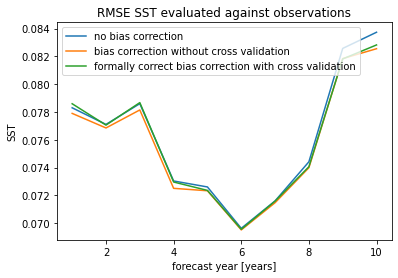

<IPython.core.display.Javascript object>

In [10]:
metric = "rmse"
hindcast.verify(metric=metric, comparison="e2o", dim="init", alignment="same_verifs")[
    "SST"
].plot(label="no bias correction")
hindcast.remove_bias(cross_validate=False, alignment="same_verifs").verify(
    metric=metric, comparison="e2o", dim="init", alignment="same_verifs"
).SST.plot(label="bias correction without cross validation")
hindcast.remove_bias(cross_validate=True, alignment="same_verifs").verify(
    metric=metric, comparison="e2o", dim="init", alignment="same_verifs"
).SST.plot(label="formally correct bias correction with cross validation")
plt.legend()
plt.title(f"{metric.upper()} SST evaluated against observations")
plt.show()